In [ ]:
# This command modifies the installed basicsr file to use the correct torchvision module path.
! sed -i 's/from torchvision.transforms.functional_tensor import rgb_to_grayscale/from torchvision.transforms.functional import rgb_to_grayscale/' /usr/local/lib/python3.12/dist-packages/basicsr/data/degradations.py

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

!pip install torchmetrics --quiet

!pip install basicsr
!python /content/drive/MyDrive/ReBotNET/rebot-net-main/dataset_loader.py


Mounted at /content/drive
Traceback (most recent call last):
  File "/content/drive/MyDrive/ReBotNET/rebot-net-main/dataset_loader.py", line 7, in <module>
    import utils.utils_video as utils_video
  File "/content/drive/MyDrive/ReBotNET/rebot-net-main/utils/utils_video.py", line 8, in <module>
    from basicsr.utils.file_client import FileClient
  File "/usr/local/lib/python3.12/dist-packages/basicsr/__init__.py", line 4, in <module>
    from .data import *
  File "/usr/local/lib/python3.12/dist-packages/basicsr/data/__init__.py", line 22, in <module>
    _dataset_modules = [importlib.import_module(f'basicsr.data.{file_name}') for file_name in dataset_filenames]
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/importlib/__init__.py", line 90, in import_module
    return _bootstrap._gcd_import(name[level:], package, level)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-pack

In [ ]:
#Download dataset
# Target directory on Google Drive
DRIVE_DOWNLOAD_DIR = "/content/drive/MyDrive/ReBotNET/Data_set"

# URL for the  clean test set
FILE_URL = "http://data.csail.mit.edu/tofu/testset/vimeo_test_clean.zip"
# Download dataset
print(f"Attempting to download {FILE_URL} directly to {DRIVE_DOWNLOAD_DIR}...")
! wget "$FILE_URL" -P "$DRIVE_DOWNLOAD_DIR"


In [ ]:
ZIP_PATH = "/content/drive/MyDrive/ReBotNET/Data_set/vimeo_test_clean.zip"
DRIVE_GT_PATH = "/content/drive/MyDrive/ReBotNET/Data_set/Vimeo_Test_GT"

print("Re-extracting ZIP file...")
# extract the file to the temporary location
!unzip -q "$ZIP_PATH" -d /content/vimeo_test_temp

# Clear the destination folder first (optional, but clean)
!mkdir -p "$DRIVE_GT_PATH"
!rm -rf "$DRIVE_GT_PATH/sequences" # Remove any failed or partial directory

# Inspect the contents of the newly extracted folder
print("--- Extracted Contents (Inspect Carefully) ---")
! ls -F /content/vimeo_test_temp/
print("--------------------------------------------")

In [ ]:
print("Moving files to permanent Google Drive location...")

#Move the 'sequences' folder (which contains all the frames)
!mv /content/vimeo_test_temp/vimeo_test_clean/sequences "$DRIVE_GT_PATH/sequences"

#Move the accompanying metadata file (sep_testlist.txt)
!mv /content/vimeo_test_temp/vimeo_test_clean/sep_testlist.txt "$DRIVE_GT_PATH/sep_testlist.txt"

# Clean up the entire temporary folder
!rm -rf /content/vimeo_test_temp
print("Files moved successfully. Temporary disk cleaned up.")

In [ ]:
import os
import random
from torch.utils.data import DataLoader

# --- Variables (Based on Vimeo-90K Septuplet Test Set) ---
DRIVE_GT_PATH = "/content/drive/MyDrive/ReBotNET/Data_set/Vimeo_Test_GT"

INPUT_LIST_FILE = f"{DRIVE_GT_PATH}/sep_testlist.txt"
OUTPUT_META_FILE = f"{DRIVE_GT_PATH}/meta_info.txt"

FRAME_COUNT = 7             # Vimeo-90K Septuplet sequences are 7 frames long
PLACEHOLDER_SHAPE = '(256,448,3)' # Fixed resolution for this dataset
START_FRAME_INDEX = 1       # Frames start at 'im1.png'
val_partition = set()       # Ensure this is defined globally for the script

print("Generating meta_info.txt...")

try:
    # Read the list of clip paths
    with open(INPUT_LIST_FILE, 'r') as infile:
        clip_paths = [line.strip() for line in infile if line.strip()]

    # Write the metadata in the required four-column format
    with open(OUTPUT_META_FILE, 'w') as outfile:
        for clip_path in clip_paths:
            # Format: folder frame_num (H,W,C) start_frame
            outfile.write(f'{clip_path} {FRAME_COUNT} {PLACEHOLDER_SHAPE} {START_FRAME_INDEX}\n')

    print(f"Meta info file successfully generated at: {OUTPUT_META_FILE}")
    print(f"Total clips indexed: {len(clip_paths)}")

except FileNotFoundError:
    print(f"ERROR: The list file {INPUT_LIST_FILE} was not found.")

In [ ]:
with open(OUTPUT_META_FILE, 'r') as f:
    line_number=0
    outliers_found=0
    for line in f:
        line_number += 1

        # Strip leading/trailing whitespace
        line = line.strip()

        # Skip empty lines, which could cause split errors
        if not line:
            continue

        try:
            # Get the key (the first word on the line)
            first_line_parts = line.split(' ')
            key = first_line_parts[0]

            # Split the key by the forward slash
            key_split = key.split('/')

            # Check for Outliers (Keys that dont split into exactly 2 parts)
            if len(key_split) != 2:
                print(f"OUTLIER found on Line {line_number}:")
                print(f"Key: {key}")
                print(f"Split Result: {key_split}")
                outliers_found += 1

        except IndexError:
            # This handles lines that are just spaces or malformed
            print(f"CORRUPTED LINE found on Line {line_number}: Cannot split line content.")
            outliers_found += 1

print("\n--- Summary ---")
if outliers_found == 0:
    print("No outliers found in the entire file. The key format is consistent.")
    print("The error is definitely the frame indexing/path creation in __getitem__.")
else:
    print(f"{outliers_found} OUTLIERS were found. Please fix your meta_info.txt generation.")

In [ ]:
!pip install torch torchvision


In [ ]:
import sys
import torch
from torch.utils.data import DataLoader
sys.path.append('/content/drive/MyDrive/ReBotNET/rebot-net-main')
from dataset_loader import PortraitVideoRecurrentTrainDataset
#Define paths from previous steps
DRIVE_GT_PATH = "/content/drive/MyDrive/ReBotNET/Data_set/Vimeo_Test_GT"
OUTPUT_META_FILE = f"{DRIVE_GT_PATH}/meta_info.txt"

opt = {
    #FIXED PARAMETERS
    'dataroot_gt': DRIVE_GT_PATH,
    'dataroot_lq': DRIVE_GT_PATH,
    'meta_info_file': OUTPUT_META_FILE,
    'io_backend': {'type': 'disk'},

    'num_frame': 2,
    'gt_size': 64,
    'scale': 4,

    # CONFIGURATION
    'use_hflip': True,
    'use_rot': True,
    'test_mode': False,
    'kernel_list': ['iso', 'aniso', 'generalized_iso', 'generalized_aniso', 'plateau_iso', 'plateau_aniso'],
    'kernel_prob': [0.1, 0.1, 0.2, 0.2, 0.2, 0.2],
    'random_reverse': True,
}
# Initialize with the correct class name
print("Initializing dataset...")
try:

    dataset = PortraitVideoRecurrentTrainDataset(opt)
    print(f"Total sequences for training: {len(dataset)}")
except Exception as e:
    print(f"Error during batch loading: {e}")


Initializing dataset...
Temporal augmentation interval list: [1]; random reverse is True.
Total sequences for training: 54768


In [ ]:
batch = next(iter(data_loader))
print(batch['L'].min().item(), batch['L'].max().item())
print(batch['H'].min().item(), batch['H'].max().item())


In [ ]:
from torch.utils.data import random_split, DataLoader

# Define split ratio
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=2)

print(f"Train: {len(train_dataset)} samples, Test: {len(test_dataset)} samples")


Train: 43814 samples, Test: 10954 samples


In [ ]:
# Check total samples
print("Original dataset length:", len(dataset))
print("Train subset length:", len(train_dataset))
print("Test subset length:", len(test_dataset))
print("Sum of subsets:", len(train_dataset) + len(test_dataset))


Original dataset length: 54768
Train subset length: 43814
Test subset length: 10954
Sum of subsets: 54768


In [ ]:
import sys
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import torchmetrics
from time import time

# PATH SETUP
sys.path.append('/content/drive/MyDrive/ReBotNET/rebot-net-main')
from models.archs import rebotnet as net  # Import model

# CONFIGURATION
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device in use: {device}")

pa_frames = 2
img_size = [2, 384, 384]  # temporal dim, H, W
batch_size = 4
num_epochs = 1


# 3. INITIALIZE MODEL
model = net(
    upscale=1, img_size=img_size, window_size=[6,8,8],
    depths=[3,3,3,3], indep_reconsts=[9,10],
    embed_dims=[64,80,108,116],
    num_heads=[6]*13, pa_frames=pa_frames, deformable_groups=12,
    mlp_dim=256, bottle_depth=4, bottle_dim=116,
    dropout=0.1, patch_size=1
).to(device)

criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


# METRICS (PSNR, SSIM)
psnr_metric = torchmetrics.image.PeakSignalNoiseRatio(data_range=1.0).to(device)
ssim_metric = torchmetrics.image.StructuralSimilarityIndexMeasure(data_range=1.0).to(device)

# TRAINING LOOP
model.train()
for epoch in range(num_epochs):
    epoch_loss = 0
    epoch_psnr = 0
    epoch_ssim = 0

    # tqdm shows batch number and ETA
    loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]", leave=False)

    for batch_idx, batch in enumerate(loop, 1):
        lq = batch['L'].to(device)  # (b, t, c, h, w)
        hr = batch['H'].to(device)
        b, t, c, h, w = lq.shape

        optimizer.zero_grad()
        loss = 0
        batch_psnr = 0
        batch_ssim = 0

        # Auto-regressive frame prediction
        prev_pred = lq[:, 0]  # use first frame as prev prediction
        for i in range(t):
            current_frame = lq[:, i]
            input_frame = torch.stack([prev_pred, current_frame], dim=1)  # (b, 2, c, h, w)
            output = model(input_frame)
            gt = hr[:, i]

            # Compute loss + metrics
            loss_i = criterion(output, gt)
            psnr_i = psnr_metric(output, gt)
            ssim_i = ssim_metric(output, gt)

            loss += loss_i
            batch_psnr += psnr_i.item()
            batch_ssim += ssim_i.item()

            prev_pred = output.detach()

        loss.backward()
        optimizer.step()

        # Update epoch stats
        epoch_loss += loss.item() / t
        epoch_psnr += batch_psnr / t
        epoch_ssim += batch_ssim / t

        # Update tqdm description: batch number and ETA
        loop.set_description(f"Epoch [{epoch+1}/{num_epochs}] Batch [{batch_idx}/{len(train_loader)}]")

    # Print metrics only after the epoch
    print(f"\nEpoch [{epoch+1}/{num_epochs}] Summary:")
    print(f"  Avg Loss: {epoch_loss/len(train_loader):.6f}")
    print(f"  Avg PSNR: {epoch_psnr/len(train_loader):.2f}")
    print(f"  Avg SSIM: {epoch_ssim/len(train_loader):.4f}")


/usr/local/lib/python3.12/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


Device in use: cuda



Epoch [1/1] Summary:
  Avg Loss: 0.016379
  Avg PSNR: 30.72
  Avg SSIM: 0.8795


In [ ]:
# After the whole training loop
final_model_path = "/content/drive/MyDrive/ReBotNET/rebotnet_final.pth"
torch.save(model.state_dict(), final_model_path)
print(f"\nTraining complete. Final model saved at: {final_model_path}")


Training complete. Final model saved at: /content/drive/MyDrive/ReBotNET/rebotnet_final.pth


In [ ]:
import sys
import os
import time
import torch
from tqdm import tqdm
import torchmetrics

# PATH SETUP
sys.path.append('/content/drive/MyDrive/ReBotNET/rebot-net-main')
from models.archs import rebotnet as net  # Import model

# CONFIG
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device in use: {device}")

pa_frames = 2
img_size = [2, 384, 384]

# MODEL INIT
model = net(
    upscale=1, img_size=img_size, window_size=[6,8,8],
    depths=[3,3,3,3], indep_reconsts=[9,10],
    embed_dims=[64,80,108,116],
    num_heads=[6]*13, pa_frames=pa_frames, deformable_groups=12,
    mlp_dim=256, bottle_depth=4, bottle_dim=116,
    dropout=0.1, patch_size=1
).to(device)

# LOAD CHECKPOINT
ckpt_path = "/content/drive/MyDrive/ReBotNET/rebotnet_final.pth"
assert os.path.exists(ckpt_path), f"Checkpoint not found: {ckpt_path}"
model.load_state_dict(torch.load(ckpt_path, map_location=device))
model.eval()

# METRICS (PSNR + SSIM)
psnr_metric = torchmetrics.image.PeakSignalNoiseRatio(data_range=1.0).to(device)
ssim_metric = torchmetrics.image.StructuralSimilarityIndexMeasure(data_range=1.0).to(device)

# EVALUATION
total_psnr = 0.0
total_ssim = 0.0
total_frames = 0
total_latency = 0.0

with torch.no_grad():
    progress = tqdm(enumerate(test_loader), total=len(test_loader), desc="Evaluating", unit="batch")

    for batch_idx, batch in progress:
        lq = batch['L'].to(device)  # (b, t, c, h, w)
        hr = batch['H'].to(device)
        b, t, c, h, w = lq.shape

        batch_psnr = 0.0
        batch_ssim = 0.0
        frame_count = 0

        # Auto-regressive prediction per video
        prev_pred = lq[:, 0]  # initial frame for each video in batch
        for i in range(t):
            current_frame = lq[:, i]
            input_frame = torch.stack([prev_pred, current_frame], dim=1)  # (b, 2, c, h, w)

            start_time = time.time()
            output = model(input_frame)
            latency = time.time() - start_time
            total_latency += latency

            gt = hr[:, i]
            psnr_i = psnr_metric(output, gt)
            ssim_i = ssim_metric(output, gt)

            batch_psnr += psnr_i.item() * b
            batch_ssim += ssim_i.item() * b
            frame_count += b
            total_frames += b

            prev_pred = output.detach()

        # Average for this batch
        batch_psnr /= frame_count
        batch_ssim /= frame_count
        total_psnr += batch_psnr
        total_ssim += batch_ssim

        progress.set_postfix({
            "Batch_PSNR": f"{batch_psnr:.2f}",
            "Batch_SSIM": f"{batch_ssim:.4f}"
        })

# FINAL RESULTS

avg_psnr = total_psnr / len(test_loader)
avg_ssim = total_ssim / len(test_loader)
avg_latency = (total_latency / total_frames) * 1000  # ms per frame

print("\n Evaluation Complete")
print(f"Average PSNR : {avg_psnr:.2f} dB")
print(f"Average SSIM : {avg_ssim:.4f}")
print(f"Average Latency per Frame : {avg_latency:.2f} ms")


Device in use: cuda


Evaluating: 100%|██████████| 2739/2739 [18:12<00:00,  2.51batch/s, Batch_PSNR=27.85, Batch_SSIM=0.8286]


✅ Evaluation Complete
Average PSNR : 31.14 dB
Average SSIM : 0.8900
Average Latency per Frame : 30.87 ms


✅ Loaded weights from: /content/drive/MyDrive/ReBotNET/rebotnet_final.pth
🎞 Total frames loaded: 49
✅ Enhanced 49 frames


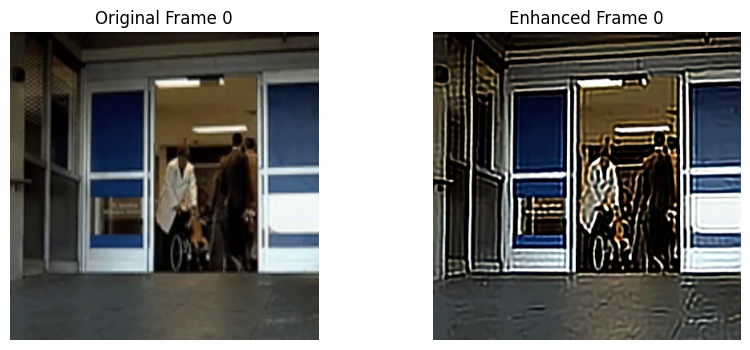

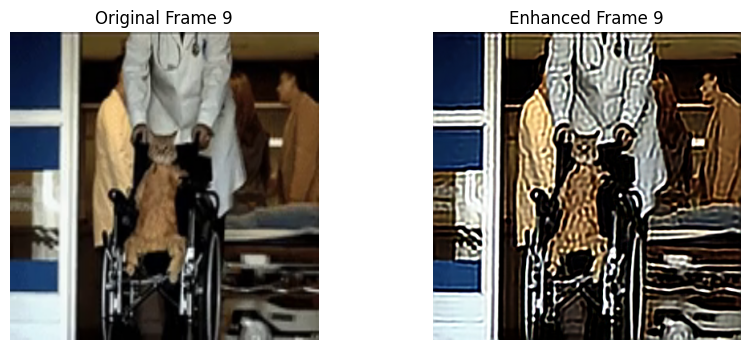

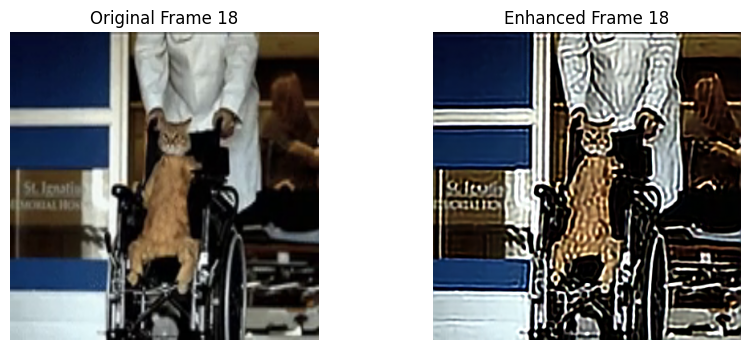

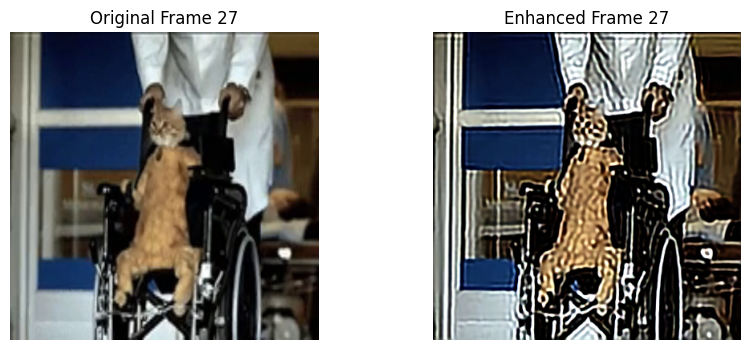

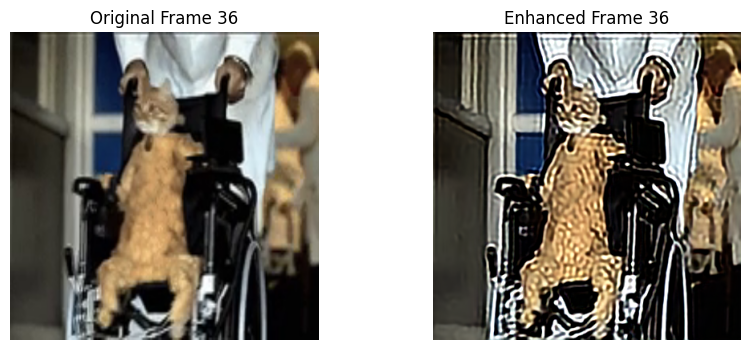

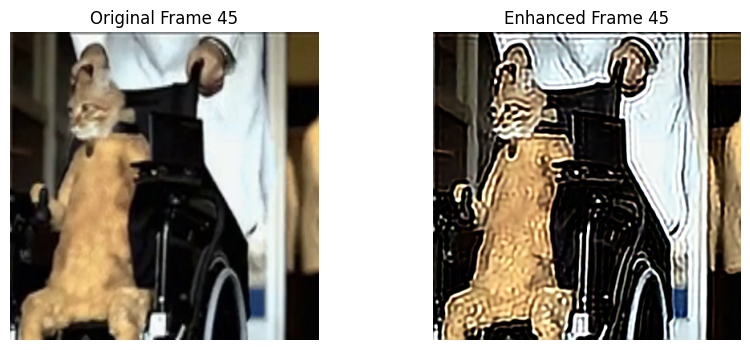

In [ ]:
import cv2
import torch
import numpy as np
import sys
import matplotlib.pyplot as plt
import os

# -----------------------------
# PATH SETUP
# -----------------------------
sys.path.append('/content/drive/MyDrive/ReBotNET/rebot-net-main/models')
from archs import rebotnet as net  # Make sure 'archs/rebotnet.py' exists

# -----------------------------
# CONFIGURATION
# -----------------------------
video_path = "/content/drive/MyDrive/Sample/in.mp4"
weights_path = "/content/drive/MyDrive/ReBotNET/rebotnet_final.pth"  # <-- change this to your actual .pth path
device = 'cuda' if torch.cuda.is_available() else 'cpu'
img_size = (384, 384)   # (W, H)
pa_frames = 2
model_variant = "rebot_M"

# -----------------------------
# MODEL INITIALIZATION
# -----------------------------
def load_model(model_variant):
    if model_variant == "rebot_M":
        return net(upscale=1, img_size=[2,384,384], window_size=[6,8,8],
                   depths=[3,3,3,3], indep_reconsts=[9,10],
                   embed_dims=[64,80,108,116], num_heads=[6]*13,
                   pa_frames=pa_frames, deformable_groups=12,
                   mlp_dim=256, bottle_depth=4, bottle_dim=116,
                   dropout=0.1, patch_size=1)
    else:
        raise ValueError("Only rebot_M is configured here.")

model = load_model(model_variant).to(device)

# Load trained weights (.pth)
if os.path.exists(weights_path):
    checkpoint = torch.load(weights_path, map_location=device)
    if "params" in checkpoint:  # In case it's wrapped in a dict
        checkpoint = checkpoint["params"]
    model.load_state_dict(checkpoint)
    print(f"✅ Loaded weights from: {weights_path}")
else:
    print(f"⚠️ Warning: No weights found at {weights_path}, using random weights")

model.eval()

# -----------------------------
# LOAD VIDEO
# -----------------------------
cap = cv2.VideoCapture(video_path)
frames = []

while True:
    ret, frame = cap.read()
    if not ret:
        break
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame = cv2.resize(frame, img_size)
    frames.append(frame)

cap.release()

frames = np.stack(frames, axis=0)  # [T, H, W, C]
frames = frames.astype(np.float32) / 255.0
frames = torch.from_numpy(frames).permute(0, 3, 1, 2).unsqueeze(0).to(device)  # [1, T, C, H, W]
T = frames.shape[1]
print(f"🎞 Total frames loaded: {T}")

# -----------------------------
# ENHANCE FRAMES
# -----------------------------
enhanced_frames = []

with torch.no_grad():
    first_frame = frames[:, 0]
    first_input = torch.stack([first_frame, first_frame], dim=1)
    first_output = model(first_input)
    prev_pred = first_output
    enhanced_frames.append(first_output)

    for i in range(1, T):
        curr_frame = frames[:, i]
        clip = torch.stack([prev_pred, curr_frame], dim=1)
        output = model(clip)
        prev_pred = output
        enhanced_frames.append(output)

print(f"✅ Enhanced {len(enhanced_frames)} frames")

# -----------------------------
# PLOT ORIGINAL VS ENHANCED
# -----------------------------
for i in range(0, len(enhanced_frames), max(1, len(enhanced_frames)//5)):
    orig = frames[0, i].permute(1, 2, 0).cpu().numpy()
    enh = enhanced_frames[i].squeeze(0).permute(1, 2, 0).cpu().numpy()

    orig = np.clip(orig, 0, 1)
    enh = np.clip(enh, 0, 1)

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(orig)
    plt.title(f"Original Frame {i}")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(enh)
    plt.title(f"Enhanced Frame {i}")
    plt.axis("off")

    plt.show()


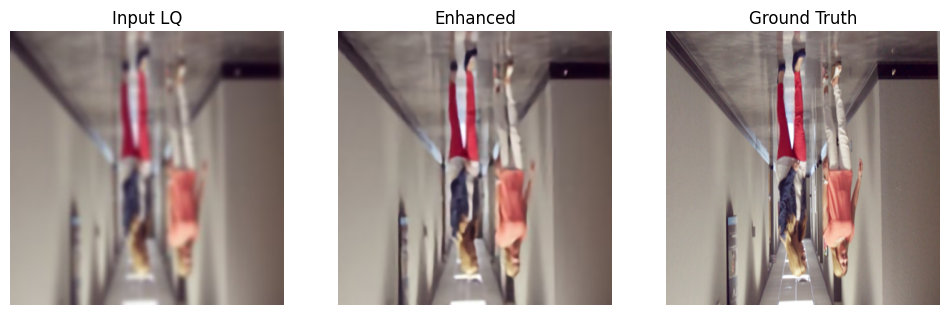

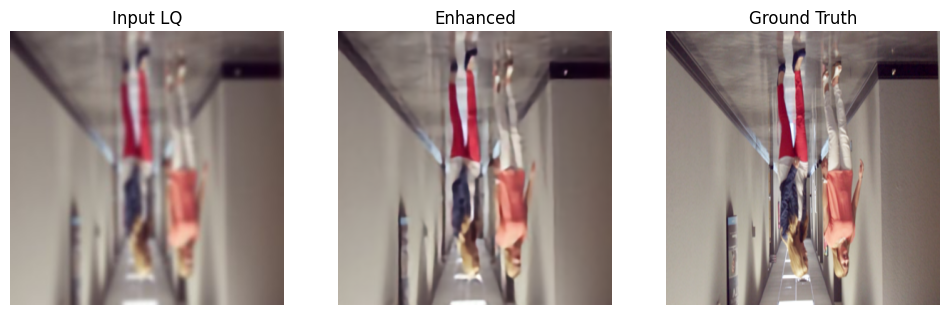

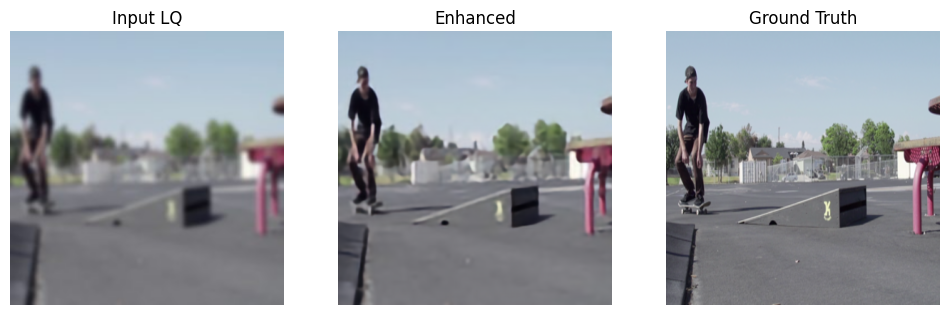

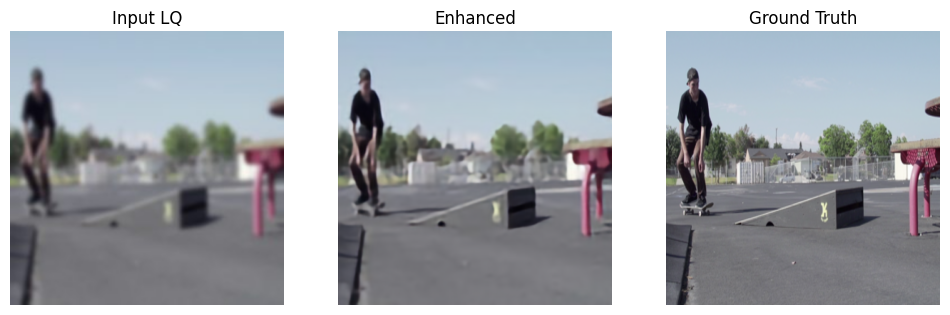

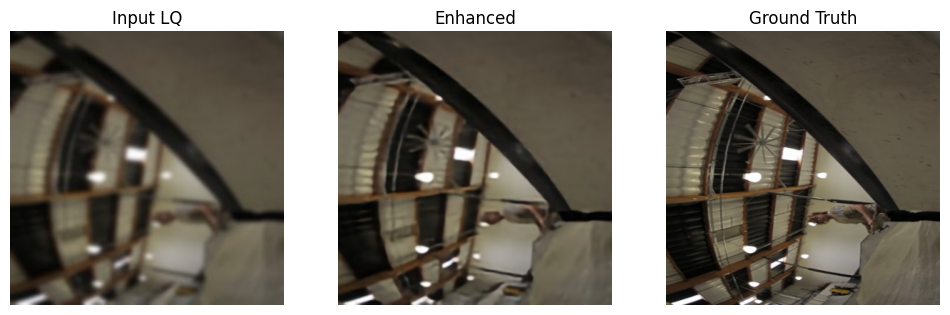

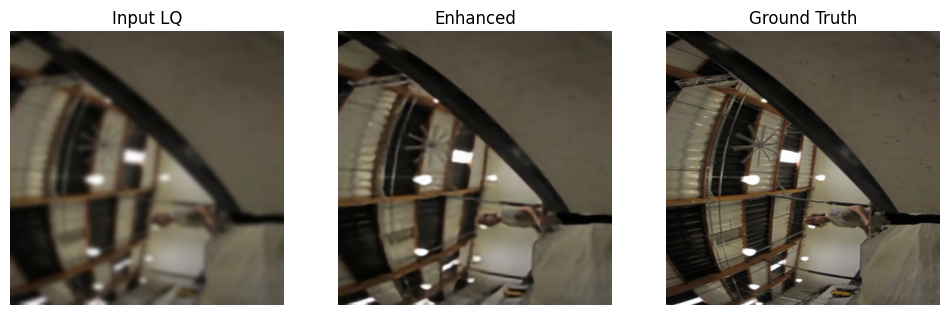

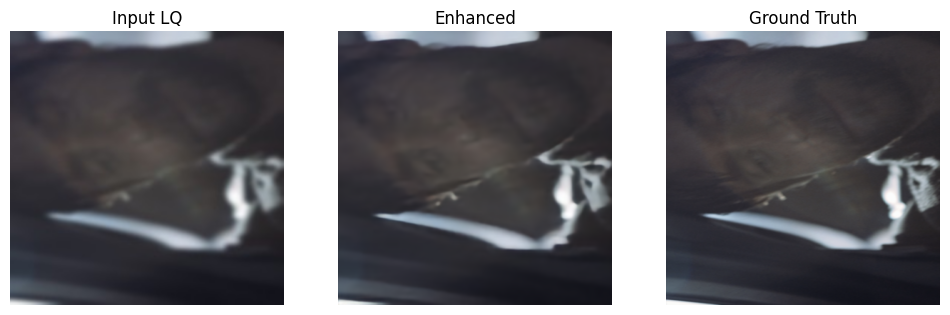

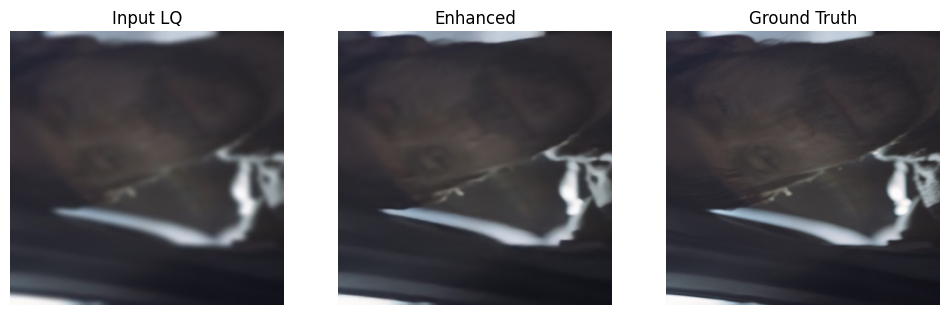

In [ ]:
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import sys

# --- PATH SETUP ---
sys.path.append('/content/drive/MyDrive/ReBotNET/rebot-net-main')
from models.archs import rebotnet as net
from dataset_loader import PortraitVideoRecurrentTrainDataset  # adjust path if needed

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# -----------------------------
# LOAD MODEL
# -----------------------------
pa_frames = 2
img_size = [2, 384, 384]
model_variant = "rebot_M"
model_path = "/content/drive/MyDrive/ReBotNET/rebotnet_final.pth"

model = net(
    upscale=1, img_size=img_size, window_size=[6,8,8],
    depths=[3,3,3,3], indep_reconsts=[9,10],
    embed_dims=[64,80,108,116],
    num_heads=[6]*13, pa_frames=pa_frames, deformable_groups=12,
    mlp_dim=256, bottle_depth=4, bottle_dim=116,
    dropout=0.1, patch_size=1
).to(device)

model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()


# -----------------------------
# GET SMALL BATCH
# -----------------------------
batch = next(iter(test_loader))
lq_frames = batch['L'].to(device)   # [B, T, C, H, W]
gt_frames = batch['H'].to(device)    # [B, T, C, H, W]
B, T, C, H, W = lq_frames.shape

# -----------------------------
# RUN MODEL ON BATCH
# -----------------------------
enhanced_batch = []

with torch.no_grad():
    for b in range(B):
        enhanced_frames = []
        prev_pred = lq_frames[b, 0]  # initial frame
        # Process each frame sequentially
        for t in range(T):
            curr_frame = lq_frames[b, t]
            input_clip = torch.stack([prev_pred, curr_frame], dim=0).unsqueeze(0)  # [1,2,C,H,W]
            output = model(input_clip)
            prev_pred = output.squeeze(0).detach()
            enhanced_frames.append(prev_pred)
        enhanced_batch.append(torch.stack(enhanced_frames, dim=0))  # [T,C,H,W]

enhanced_batch = torch.stack(enhanced_batch, dim=0)  # [B,T,C,H,W]

# -----------------------------
# VISUALIZE SAMPLE FRAMES
# -----------------------------
for b in range(B):
    for t in range(T):
        inp = lq_frames[b,t].permute(1,2,0).cpu().numpy()
        out = enhanced_batch[b,t].permute(1,2,0).cpu().numpy()
        gt  = gt_frames[b,t].permute(1,2,0).cpu().numpy()

        # clamp to [0,1]
        inp = np.clip(inp, 0, 1)
        out = np.clip(out, 0, 1)
        gt = np.clip(gt, 0, 1)

        plt.figure(figsize=(12,4))
        plt.subplot(1,3,1)
        plt.imshow(inp)
        plt.title("Input LQ")
        plt.axis('off')

        plt.subplot(1,3,2)
        plt.imshow(out)
        plt.title("Enhanced")
        plt.axis('off')

        plt.subplot(1,3,3)
        plt.imshow(gt)
        plt.title("Ground Truth")
        plt.axis('off')

        plt.show()
